<span style="font-size:20pt;font-weight:bold">GOJEK's Code Test - Data Scientist</font>
<br>

**Author:** 
<br>
Muhammad Insan Aprilian (insanaprilian50@gmail.com)
<br>
<br>

<span style="font-size:16pt;font-weight:bold">Problem Statement</font>
<br>


You are being asked to create a credit scoring model for a lending company. You are given a file with historical data. 
1.	The upper management wants the overall default rate of their portfolio to be below 2.5%, please provide recommendation on the optimal credit score cutoff rate. 
2.	Please create a credit score for each individual, validate your solution, and provide guidance on the next steps. 
3.	Please create deciles by credit score and provide risk and default levels by deciles (by decile and cumulative). Bonus if you can provide confidence (or methodology how you would do it) for your scores/default rates by bin. 


<span style="font-size:16pt;font-weight:bold">The Data Science Workflow</font>
**<p>1.  Import Packages</p>**

**<p>2.  Import Data</p>**
<p>&nbsp; &nbsp;     2.1.  Metadata Definition</p>

**<p>3.  Data Exploration</p>**
<p>&nbsp; &nbsp;     3.1.  Missing Value Check</p>
<p>&nbsp; &nbsp;     3.2.  Outlier Check (IQR based)</p>
<p>&nbsp; &nbsp;     3.3.  Predictor Distribution to Target</p>
<p>&nbsp; &nbsp;     3.4.  Data Split</p>
<p>&nbsp; &nbsp;     3.5.  Data Transformation</p>
<p>&nbsp; &nbsp;&nbsp; &nbsp;     3.5.1.  Categorical - Woe Encoder</p>
<p>&nbsp; &nbsp;&nbsp; &nbsp;     3.5.2.  Numerical - Missing Imputation</p>
<p>&nbsp; &nbsp;&nbsp; &nbsp;     3.5.3.  Numerical - Standardization</p>

**<p>4.  Predictor Selection</p>**    
<p>&nbsp; &nbsp;     4.1.  Predictor power comparison</p>
<p>&nbsp; &nbsp;     4.2.  Correlations</p>

**<p>5.  Modeling</p>**
<p>&nbsp; &nbsp;     5.1.  Logistic Regression Session</p>
<p>&nbsp; &nbsp;&nbsp; &nbsp;     5.1.1.  Tuning parameter</p>
<p>&nbsp; &nbsp;&nbsp; &nbsp;     5.1.2.  Train the model</p>
<p>&nbsp; &nbsp;     5.2.  XGBoost Session</p>
<p>&nbsp; &nbsp;&nbsp; &nbsp;     5.2.1.  Train initial model</p>
<p>&nbsp; &nbsp;&nbsp; &nbsp;     5.2.2.  Evaluate predictor</p>
<p>&nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp;     5.2.2.1.  Weight of each predictor</p>
<p>&nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp;     5.2.2.2.  Gain of each predictor</p>
<p>&nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp;     5.2.2.3.  Selected Predictor</p>
<p>&nbsp; &nbsp;&nbsp; &nbsp;     5.2.3.  Tuning parameter</p>
<p>&nbsp; &nbsp;&nbsp; &nbsp;     5.2.4.  Final Model</p>
<p>&nbsp; &nbsp;&nbsp; &nbsp;     5.2.5.  Evaluate final model</p>
<p>&nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp;     5.2.5.1.  Gain of each predictor</p>

**<p>6.  Score the dataset</p>**

**<p>7.  Performance characteristics</p>**
<p>&nbsp; &nbsp;     7.1.  Performance per sample</p>
<p>&nbsp; &nbsp;     7.2.  ROC Curve</p>
<p>&nbsp; &nbsp;     7.3.  Score Linearity on Holdout Sample</p>
<p>&nbsp; &nbsp;     7.4.  Cut-Off Estimation</p>

**<p>8.  Conclusion</p>**

# Import Packages

- `time` - datetime - ability to get current time for logs
- `math` - basic mathematical functions (as logarithm etc.))
- `numpy` - for mathematical,and numerical calculations
- `scipy` - for metrics evaluation calculations
- `pandas` - for work with large data structures
- `scikit` - all important machine learning (and statistical) algorithms used for training the models
- `matplotlib` - for plotting the charts
- `seaborn` - for statistical visualisations
- `xgboost` - gradient boosting used for training the models
- `category_encoders` - for category type transformation
- `ia_pkg` - for combined function used in this notebook

In [1]:
import pandas as pd
import numpy as np
import time
import datetime

import ia_pkg

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML, Markdown

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Checking used library version
ia_pkg.pkg_version()

 Package version check
numpy: 1.19.2
pandas: 1.1.3
sklearn: 0.23.2
matplotlib: 3.3.2
seaborn: 0.11.0
scipy: 1.5.2
xgboost: 0.90
category_encoders : 2.2.2



# Import Data

In [3]:
#Import data from CSV
data = pd.read_csv('credit_ds_v3.csv', index_col='X')
print('Data loaded on', datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

Data loaded on 2020-12-09 22:18:27


In [4]:
#Running DataFrame optimizer to reduce memory usage
from ia_pkg.function import optimizer
data = optimizer(data)

Memory usage of dataframe is: 2.86 MB
Memory usage after optimization is: 1.46 MB
Decreased by 49.0%


In [5]:
#Remove rows with duplicated index
data=data[~data.index.duplicated(keep='first')]

In [6]:
print('Number of rows:',data.shape[0])
print('Number of columns:',data.shape[1])

Number of rows: 15645
Number of columns: 23


In [7]:
data.head()

,number_of_cards,outstanding,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill,branch_code,payment_ratio,overlimit_percentage,...,default_flag,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,remaining_bill_per_limit,total_usage_per_limit,total_3mo_usage_per_limit,total_6mo_usage_per_limit,utilization_3month,utilization_6month
X,,,,,,,,,,,,,,,,,,,,,
2,2,268691,10000000.0,254564.0,0.0,1012.0,0.0,A,0.000000,0.0,...,0,0.750000,1012.0,0.0,0.000000,0.000101,0.000000,0.000000,0.004232,0.000300
3,3,6769149,28000000.0,4159779.0,0.0,0.0,0.0,A,100.000000,0.0,...,0,10.750000,0.0,0.0,0.000000,0.000000,0.040518,0.047703,0.249389,NaN
5,2,9402085,10000000.0,6099283.0,0.0,2666558.0,5951865.0,A,95.989998,0.0,...,0,1.666667,2666558.0,2975932.5,0.595186,0.266656,0.323027,0.131162,0.707865,0.336571
6,2,6227439,80000000.0,2081248.0,0.0,3690250.0,4613435.0,A,0.000000,0.0,...,0,10.250000,3690250.0,2306717.5,0.057668,0.046128,0.017184,0.117513,0.038964,0.181863
7,2,3906290,4000000.0,2043682.0,0.0,230400.0,3314046.0,A,18.469999,0.0,...,0,4.666667,230400.0,1657023.0,0.828511,0.057600,0.018750,0.166667,1.014776,0.977231


## Metadata Definition

In [8]:
col_target = 'default_flag'

cols_pred = list(data.drop(col_target,axis=1).columns)

cols_pred_num = list(data[cols_pred].select_dtypes(include=np.number).columns)
cols_pred_cat = list(data[cols_pred].select_dtypes(include=np.object).columns)

print('List of numerical predictors:', len(cols_pred_num),'\n\n', data[cols_pred_num].dtypes)
print('\nList of categorical predictors: ', len(cols_pred_cat), '\n\n', data[cols_pred_cat].dtypes)

List of numerical predictors: 21 

 number_of_cards                         uint8
outstanding                            uint32
credit_limit                          float32
bill                                  float32
total_cash_usage                      float32
total_retail_usage                    float32
remaining_bill                        float32
payment_ratio                         float32
overlimit_percentage                  float32
payment_ratio_3month                  float32
payment_ratio_6month                  float32
delinquency_score                     float32
years_since_card_issuing              float32
total_usage                           float32
remaining_bill_per_number_of_cards    float32
remaining_bill_per_limit              float32
total_usage_per_limit                 float32
total_3mo_usage_per_limit             float32
total_6mo_usage_per_limit             float32
utilization_3month                    float32
utilization_6month                    float3

# Data Exploration

Showing the statistical summary, could help us on preliminary investigation on dataset

In [9]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
number_of_cards,15645,NaN,NaN,NaN,2.50604,1.01254,1,2,2,3,16
outstanding,15645,NaN,NaN,NaN,1.16062e+07,2.40794e+07,0,1.9928e+06,4.71878e+06,1.06653e+07,7.98059e+08
credit_limit,15645,NaN,NaN,NaN,2.08205e+07,2.9555e+07,3e+06,5e+06,9e+06,2.2e+07,1e+09
bill,15645,NaN,NaN,NaN,8.07646e+06,1.75998e+07,20043,813947,3.14137e+06,7.40407e+06,6.28e+08
total_cash_usage,15600,NaN,NaN,NaN,74576.1,617732,0,0,0,0,2.88406e+07
total_retail_usage,15645,NaN,NaN,NaN,2.02481e+06,7.90958e+06,-1.56672e+07,0,200000,1.3962e+06,2.85e+08
remaining_bill,15645,NaN,NaN,NaN,8.14679e+06,1.92466e+07,0,0,2.74716e+06,7.14246e+06,4.44e+08
branch_code,15450,11,A,8705,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_ratio,15645,NaN,NaN,NaN,7.03691,792.892,-49860,-17.3,0,44.6,68983
overlimit_percentage,15619,NaN,NaN,NaN,3.33066,9.21501,0,0,0,1.01,190


## Missing Value Check

In [10]:
# Investigate columns with null values
missingCol = data.isnull().sum()
print("There are", len(missingCol[missingCol != 0]),"columns with missing value")

There are 5 columns with missing value


In [11]:
# Investigate null rate of contained null columns
missingRate = []
for col in cols_pred:
    if data[col].isnull().any():
        missingRate.append({'Predictor' : col,
                       'Missing rate' : data[col].isnull().sum() / data.shape[0]})
pd.DataFrame(missingRate).set_index('Predictor').sort_values('Missing rate',ascending=False)

,Missing rate
Predictor,
utilization_6month,0.181655
branch_code,0.012464
delinquency_score,0.005625
total_cash_usage,0.002876
overlimit_percentage,0.001662


## Outlier Check (IQR based)

number_of_cards 's outliers count: 761


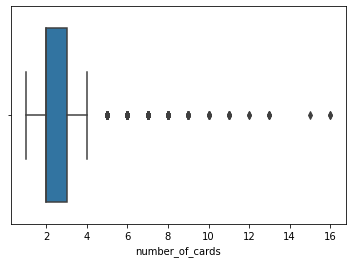

outstanding 's outliers count: 1800


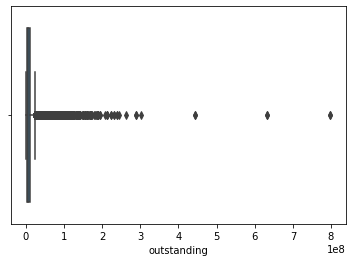

credit_limit 's outliers count: 2297


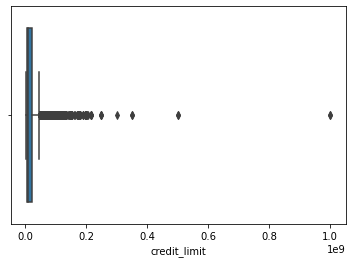

bill 's outliers count: 1828


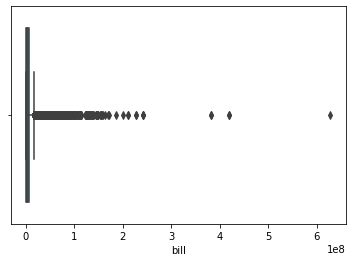

total_cash_usage 's outliers count: 736


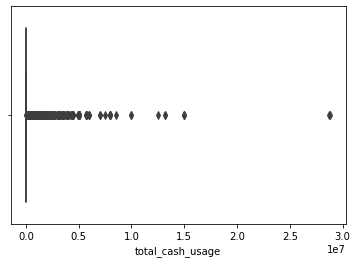

total_retail_usage 's outliers count: 2045


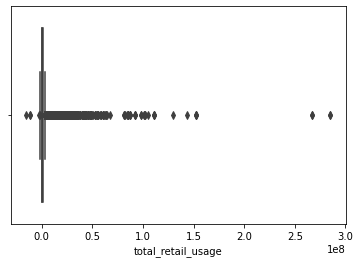

remaining_bill 's outliers count: 1875


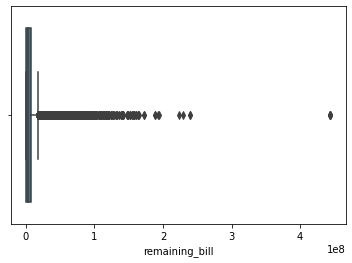

payment_ratio 's outliers count: 500


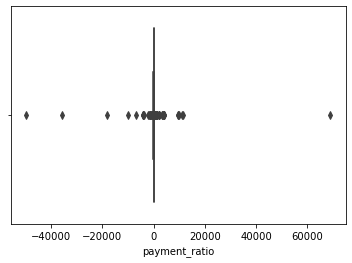

overlimit_percentage 's outliers count: 3543


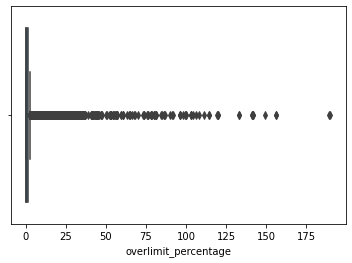

payment_ratio_3month 's outliers count: 217


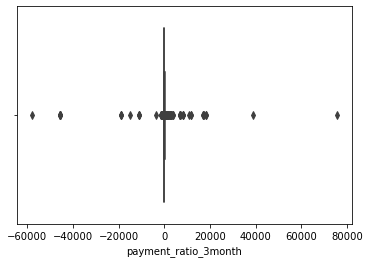

payment_ratio_6month 's outliers count: 261


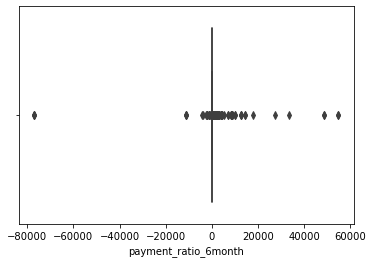

delinquency_score 's outliers count: 163


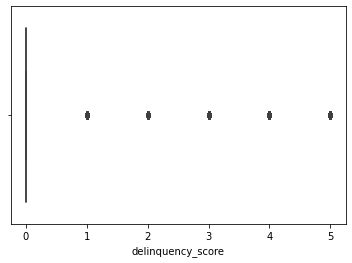

years_since_card_issuing 's outliers count: 271


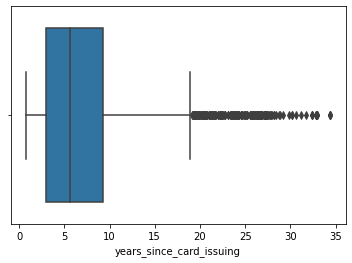

total_usage 's outliers count: 1994


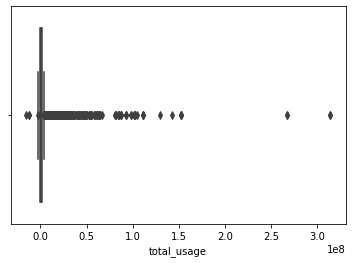

remaining_bill_per_number_of_cards 's outliers count: 1565


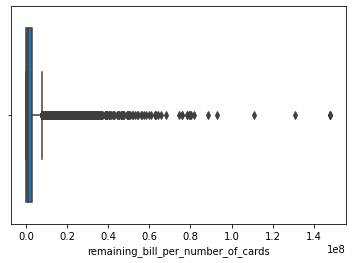

remaining_bill_per_limit 's outliers count: 11


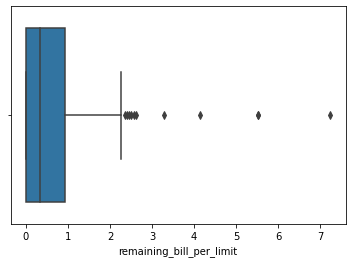

total_usage_per_limit 's outliers count: 1665


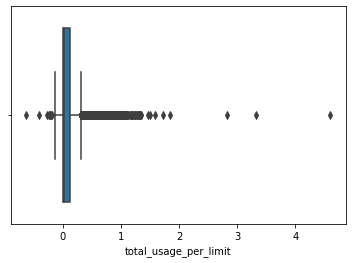

total_3mo_usage_per_limit 's outliers count: 763


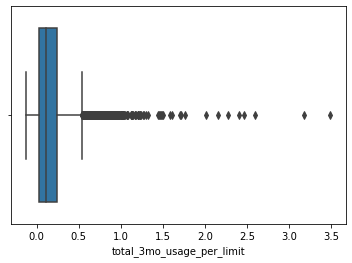

total_6mo_usage_per_limit 's outliers count: 815


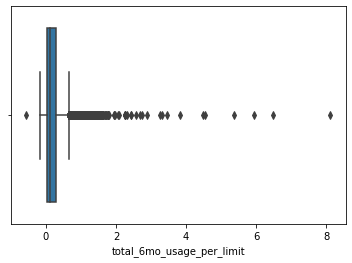

utilization_3month 's outliers count: 32


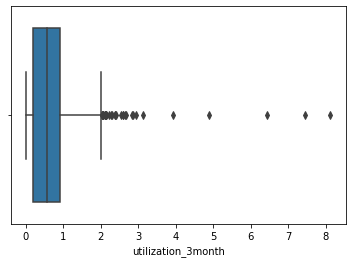

utilization_6month 's outliers count: 46


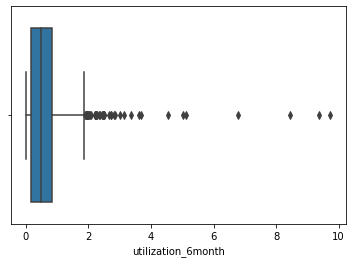

['number_of_cards',
 'outstanding',
 'credit_limit',
 'bill',
 'total_cash_usage',
 'total_retail_usage',
 'remaining_bill',
 'payment_ratio',
 'overlimit_percentage',
 'payment_ratio_3month',
 'payment_ratio_6month',
 'delinquency_score',
 'years_since_card_issuing',
 'total_usage',
 'remaining_bill_per_number_of_cards',
 'remaining_bill_per_limit',
 'total_usage_per_limit',
 'total_3mo_usage_per_limit',
 'total_6mo_usage_per_limit',
 'utilization_3month',
 'utilization_6month']

In [12]:
from ia_pkg.function import cnt_outliers, replace_with_thresholds

# Check number of 1.5 IQR based outlier
cnt_outliers(data,cols_pred_num,plot=True)

Seems all numerical predictor have an outlier, indication that high variability characteristics on the dataset

## Predictor Distribution to Target

**Categorical predictor**

***

### branch_code

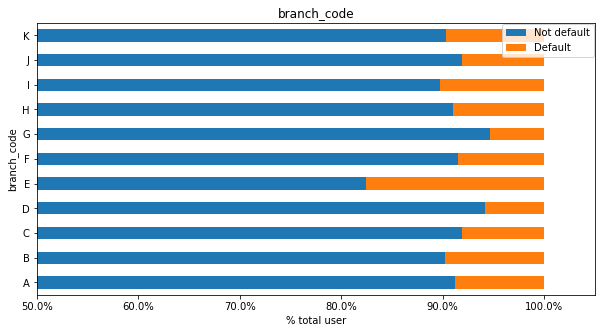

In [13]:
from ia_pkg.plots import stacked_plot, dist_plot
stacked_plot(data,
            cat_columns=cols_pred_cat,
            col_target=col_target)

From the graph, the *'E'* case on the **branch_code** would riskier than the other value, around 2 times riskier (9% on population to 17%)

**Numerical Predictor**

***

### number_of_cards

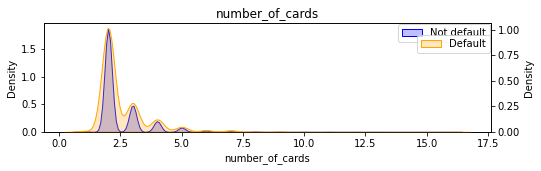

***

### outstanding

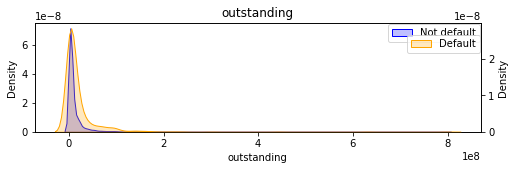

***

### credit_limit

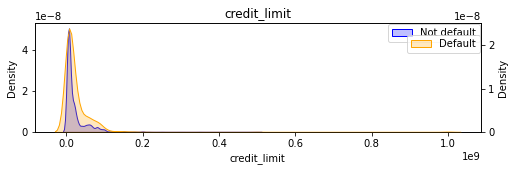

***

### bill

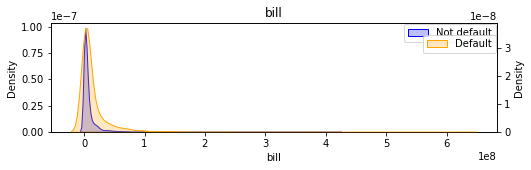

***

### total_cash_usage

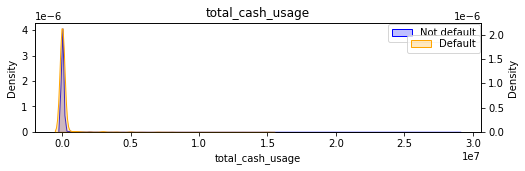

***

### total_retail_usage

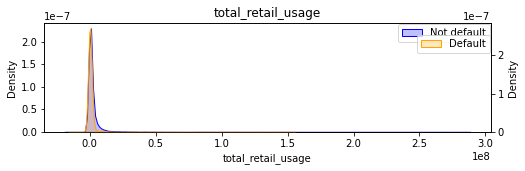

***

### remaining_bill

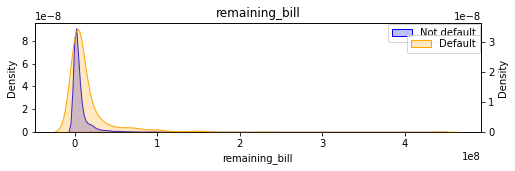

***

### payment_ratio

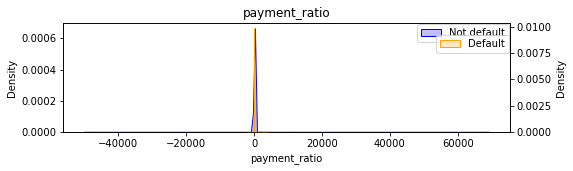

***

### overlimit_percentage

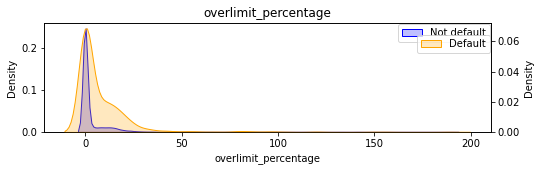

***

### payment_ratio_3month

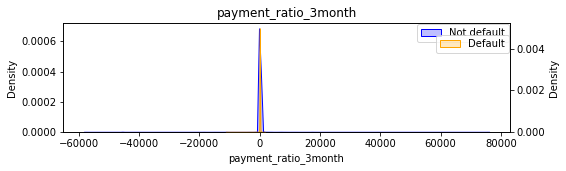

***

### payment_ratio_6month

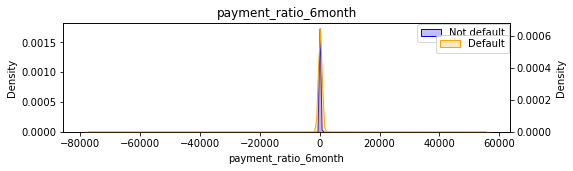

***

### delinquency_score

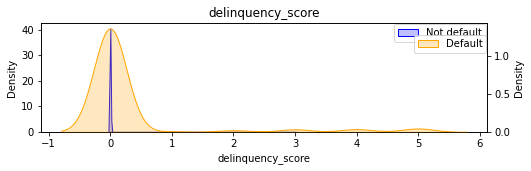

***

### years_since_card_issuing

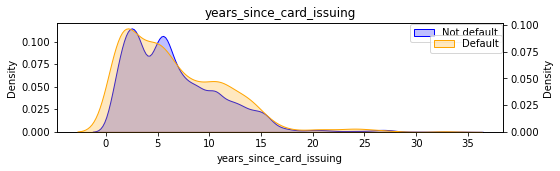

***

### total_usage

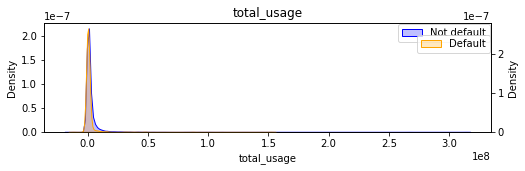

***

### remaining_bill_per_number_of_cards

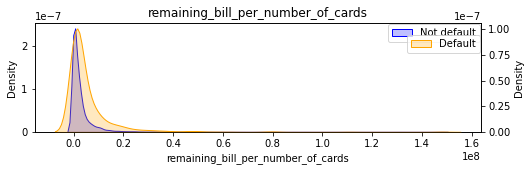

***

### remaining_bill_per_limit

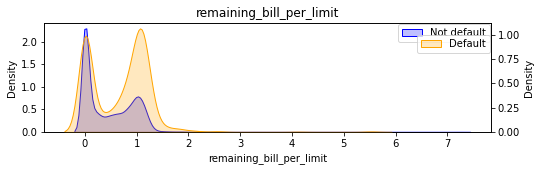

***

### total_usage_per_limit

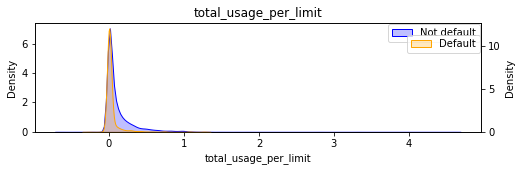

***

### total_3mo_usage_per_limit

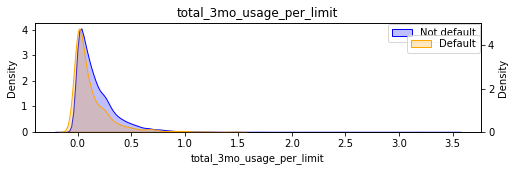

***

### total_6mo_usage_per_limit

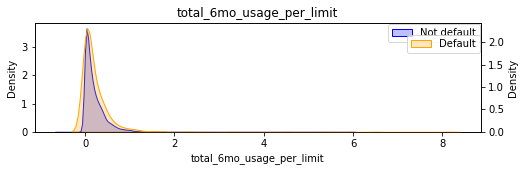

***

### utilization_3month

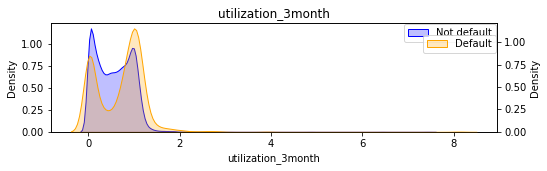

***

### utilization_6month

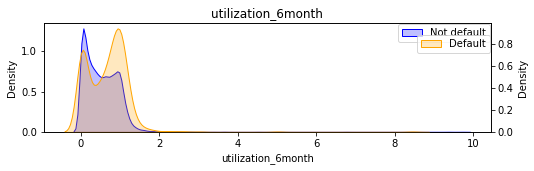

In [14]:
dist_plot(data,
            columns=cols_pred_num,
            col_target=col_target)

From the graphs, explicitely there are several predictors that have very good potential on the model. Their ability to differentiate behavior of default and non-default user is used as the base assumption.

Predictor which contained information like **delinquency score**, **Utilization**, **remaining bill** and **overlimit** assumed as the good predictor to the default. But still, further investigation needs to be done (correlation check, etc)

## Data Split

- Split data into three parts (train,valid,test)
- Adds a new column indicating to which part the observation belong
- Split is done in random
- Set the random seed so the results are replicable

In [15]:
from ia_pkg.function import data_split
data['data_type'] = data_split(data,
                               sample_sizes=[0.8,0.1,0.1],
                               sample_names=['train','test','valid'],
                               seed=42)

train    12516
valid     1565
test      1564
dtype: int64


In [16]:
#masked the sample name
train_mask = (data['data_type'] == 'train')
valid_mask = (data['data_type'] == 'valid')
test_mask = (data['data_type'] == 'test')

In [17]:
data_summary = data.groupby(['data_type']).aggregate({col_target:['sum','count']})
data_summary.columns = [col_target, 'rows']
data_summary[col_target+' rate'] = data_summary[col_target] / data_summary['rows']

display(data_summary)

,default_flag,rows,default_flag rate
data_type,,,
test,142.0,1564,0.090793
train,1121.0,12516,0.089565
valid,153.0,1565,0.097764


## Data Transformation

### Categorical - Woe Encoder

WoE method chose to transform the string-type categorical predictor to be in numeric form, WoE estimated the weight of each predictor's unique value for their ability to separate the target(in this case Default/not default).

WoE is also flexible with the null value as we can cluster it into 'special segment'. So the imputation would not be needed in this case.

In [18]:
from ia_pkg.function import woe_transform
#fit and transform WoE on categorical predictor
data_woe = woe_transform(data,
                         mask=train_mask,
                         cat_columns=cols_pred_cat,
                         col_target=col_target)

In [73]:
#Stored the WoE output on cols_woe
data_woe.columns = [i + '_woe' for i in data_woe.columns]
cols_woe = list(data_woe.columns)

data[cols_woe] = data_woe

In [74]:
woe_change = []
#Listed the tranformation result on each unique value on categorical predictor
for col,col_woe in zip(cols_pred_cat,cols_woe):
    woe_change.append(data[[col,col_woe,col_target]].fillna('Null').groupby([col,col_woe]).agg(
        {col_woe: ['count'],
         col_target : ['sum','mean']}))

for i in range(len(woe_change)):
    woe_change[i]
woe_change[0].columns = [('branch_code_woe count'),
            (   'default_flag count'),
            (   'default_flag rate')]
pd.DataFrame(woe_change[0])

,,branch_code_woe count,default_flag count,default_flag rate
branch_code,branch_code_woe,,,
A,-0.031288,8705,767.0,0.088110
B,0.058419,1351,132.0,0.097705
C,-0.092869,334,27.0,0.080838
D,-0.353662,205,12.0,0.058537
E,0.793162,649,114.0,0.175655
F,-0.045147,1697,144.0,0.084856
G,-0.619890,566,30.0,0.053004
H,0.144728,367,33.0,0.089918
I,0.131295,991,102.0,0.102926


### Numerical - Missing Imputation

Missing value imputation is done by filling the mean value to each predictor

In [75]:
cols_num_missing = data[cols_pred_num].columns[data[cols_pred_num].isnull().any()].tolist()
#filling the missing value with mean
for c in cols_num_missing:
    mean = data[c].mean()
    data[c+'_imp'] = data[c].fillna(mean,axis=0)

### Numerical - Standardization

Scaling is done on numerical predictors to avoid the outlier/bigger magnitude value effects on the model. Standardization is one of the methods for scaling, it transformed all the values by centering its mean at 0 then scales the variance at 1. 

The pros of this method is it keeping the shape of the predictor's original distribution

In [76]:
from sklearn.preprocessing import StandardScaler
#listed the imputation and non-imputation predictor for scaling
cols_pred_num2 = list(map(lambda x: x+'_imp' if x in cols_num_missing else x, cols_pred_num))       

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(data[train_mask][cols_pred_num2])
# print(scaler.mean_)
data_sd = scaler.transform(data[train_mask|valid_mask|test_mask][cols_pred_num2])

In [77]:
# stored the standardscaler output on cols_sd
cols_sd = [i+'_sd' for i in cols_pred_num]

data[cols_sd] = data_sd
data[cols_sd].head()

,number_of_cards_sd,outstanding_sd,credit_limit_sd,bill_sd,total_cash_usage_sd,total_retail_usage_sd,remaining_bill_sd,payment_ratio_sd,overlimit_percentage_sd,payment_ratio_3month_sd,...,delinquency_score_sd,years_since_card_issuing_sd,total_usage_sd,remaining_bill_per_number_of_cards_sd,remaining_bill_per_limit_sd,total_usage_per_limit_sd,total_3mo_usage_per_limit_sd,total_6mo_usage_per_limit_sd,utilization_3month_sd,utilization_6month_sd
X,,,,,,,,,,,,,,,,,,,,,
2,-0.496018,-0.465729,-0.370874,-0.433910,-0.116031,-0.249690,-0.412474,-0.012909,-0.358145,-0.042164,...,0.000003,-1.260136,-0.252671,-0.471298,-0.985386,-0.538068,-0.869207,-0.726734,-1.383978,-1.346817
3,0.479648,-0.197352,0.251065,-0.218449,-0.116031,-0.249815,-0.412474,0.119361,-0.358145,0.033772,...,0.000003,0.883030,-0.252793,-0.471298,-0.985386,-0.538569,-0.659253,-0.555666,-0.785162,-0.003964
5,-0.496018,-0.088649,-0.370874,-0.111441,-0.116031,0.079252,-0.112516,0.114057,-0.358145,0.031866,...,0.000003,-1.063679,0.068673,0.001933,0.265374,0.781630,0.804642,-0.256373,0.334700,-0.488407
6,-0.496018,-0.219717,2.047777,-0.333127,-0.116031,0.205580,-0.179969,-0.012909,-0.358145,-0.020552,...,0.000003,0.775872,0.192085,-0.104485,-0.864199,-0.310191,-0.780162,-0.305321,-1.299142,-0.883334
7,-0.496018,-0.315548,-0.578187,-0.335200,-0.116031,-0.221383,-0.245455,0.011521,-0.358145,-0.023218,...,0.000003,-0.420729,-0.225018,-0.207799,0.755697,-0.253395,-0.772049,-0.129052,1.084353,1.147024


### Wrapped up all the transformed predictor

In [78]:
cols_shortlist = []

for c in cols_sd:
    cols_shortlist.append(c)
for c in cols_woe:
    cols_shortlist.append(c)

display(cols_shortlist)

['number_of_cards_sd',
 'outstanding_sd',
 'credit_limit_sd',
 'bill_sd',
 'total_cash_usage_sd',
 'total_retail_usage_sd',
 'remaining_bill_sd',
 'payment_ratio_sd',
 'overlimit_percentage_sd',
 'payment_ratio_3month_sd',
 'payment_ratio_6month_sd',
 'delinquency_score_sd',
 'years_since_card_issuing_sd',
 'total_usage_sd',
 'remaining_bill_per_number_of_cards_sd',
 'remaining_bill_per_limit_sd',
 'total_usage_per_limit_sd',
 'total_3mo_usage_per_limit_sd',
 'total_6mo_usage_per_limit_sd',
 'utilization_3month_sd',
 'utilization_6month_sd',
 'branch_code_woe']

# Predictor Selection
<br>

Selecting the best predictor for the model, it applied to all transformed predictors. The selection metrics would be **gini, IV** (Predictive power), and **inter-predictor correlation**

## Predictive power comparison

Calculates IV and Gini of each predictor, sorts the predictors by their power. The power is calculated for each of the samples (train, validate, test).

In [79]:
from ia_pkg.metrics import iv,gini

power_tab = []
for j in range(0,len(cols_shortlist)):
    power_tab.append({'Name':cols_shortlist[j]
                    ,'Gini Train':gini(data.loc[train_mask,col_target],data.loc[train_mask,cols_shortlist[j]])                    
                    ,'Gini Validate':gini(data.loc[valid_mask,col_target],data.loc[valid_mask,cols_shortlist[j]])
                    ,'Gini Test':gini(data.loc[test_mask,col_target],data.loc[test_mask,cols_shortlist[j]])
                    ,'IV Train':iv(data.loc[train_mask,col_target],data.loc[train_mask,cols_shortlist[j]])
                    ,'IV Validate':iv(data.loc[valid_mask,col_target],data.loc[valid_mask,cols_shortlist[j]])
                    ,'IV Test':iv(data.loc[test_mask,col_target],data.loc[test_mask,cols_shortlist[j]])     
                     })
power_out = pd.DataFrame.from_records(power_tab)
power_out = power_out.set_index('Name').abs()
power_out = power_out.sort_values('Gini Validate',ascending=False)

pd.options.display.max_rows = 1000
display(power_out)
pd.options.display.max_rows = 30

,Gini Train,Gini Validate,Gini Test,IV Train,IV Validate,IV Test
Name,,,,,,
payment_ratio_3month_sd,0.443390,0.531032,0.390122,3.587264,8.306060,9.442355
total_retail_usage_sd,0.437361,0.497010,0.437536,6.131127,8.580574,9.130802
total_usage_per_limit_sd,0.425662,0.488821,0.413542,3.911063,7.414744,8.336337
total_usage_sd,0.423991,0.483910,0.397907,6.430831,8.777443,9.428548
payment_ratio_6month_sd,0.283779,0.405497,0.243507,3.177101,7.299208,8.067143
total_3mo_usage_per_limit_sd,0.244155,0.324974,0.185070,4.759086,9.485955,10.666933
remaining_bill_per_limit_sd,0.249066,0.278185,0.290753,4.180819,7.796339,8.301508
remaining_bill_sd,0.201198,0.266669,0.231632,9.280871,11.615734,12.621391
remaining_bill_per_number_of_cards_sd,0.202280,0.250481,0.234979,11.099938,11.908745,13.173565


## Correlations

Show correlation matrix of all predictor

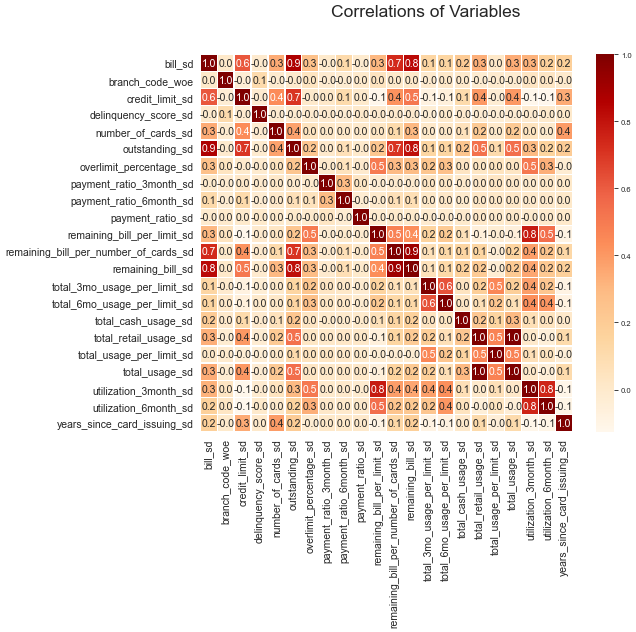

In [80]:
cormat = data[sorted(cols_shortlist)].corr()

plt.rcParams.update({'font.size': 15})
sns.set()
%matplotlib inline
%config InlineBackend.close_figures=True

fig, ax = plt.subplots(figsize=(12,10), dpi=50)
fig.suptitle('Correlations of Variables',fontsize=25)
sns.heatmap(cormat, ax=ax, annot=True, fmt="0.1f", linewidths=.5, annot_kws={"size":15},cmap="OrRd")
plt.tick_params(labelsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()
plt.clf();plt.close()

In [81]:
max_ok_correlation = 0.5

# find highest pairwise correlation (correlation greater than .. in absolute value)
hicors = []
for i in range(0,len(cormat)):
    for j in range(0,len(cormat)):
        if ((cormat.iloc[i][j] > max_ok_correlation or cormat.iloc[i][j] < -max_ok_correlation) and i < j):
            hicors.append((i,j,cormat.index[i],cormat.index[j],cormat.iloc[i][j],abs(cormat.iloc[i][j])))
hicors.sort(key= lambda x: x[5], reverse=True)

hicors2 = pd.DataFrame(list(zip(*list(zip(*hicors))[2:5])), columns = ['predictor_1', 'predictor_2', 'corr'])

# print list of highest correlations
hicors2

,predictor_1,predictor_2,corr
0,total_retail_usage_sd,total_usage_sd,0.997217
1,remaining_bill_per_number_of_cards_sd,remaining_bill_sd,0.913902
2,bill_sd,outstanding_sd,0.871068
3,bill_sd,remaining_bill_sd,0.832762
4,outstanding_sd,remaining_bill_sd,0.811607
5,remaining_bill_per_limit_sd,utilization_3month_sd,0.783759
6,utilization_3month_sd,utilization_6month_sd,0.750076
7,bill_sd,remaining_bill_per_number_of_cards_sd,0.738752
8,outstanding_sd,remaining_bill_per_number_of_cards_sd,0.712734
9,credit_limit_sd,outstanding_sd,0.707317


Combining output set from these selection methods, we choosing the predictor which placed on top individual predictive power and eliminate which both ranked on bottom(low gini) and having inter-predictor correlation (>0.5)


This new predictor set expected can prevent the low quality and mulitcollinearity issue that may occur on the model(e.g. Logistic Regression)

# Modeling

Modeling using two methods (CV Logistic Regression and XGBoost) on training data set. We take a different set of predictors for each model.

For Logistic Regression, we take transformed(*WoE* and *Imputation-Standardization*) and selected(*individual gini* and *correlation-based*) predictor called **pred_lr**

For XGBoost, we take transformed WoE and non-transformed numerical predictors (leave it as it is), XGBoost decision-tree is robust on outlier and null values so we confidently don't use numerical transformation on this. The set called **pred_xgb**

## Logistic Regression Session

Selected predictor for Logistic Regression

In [82]:
cols_shortlist2 = ['number_of_cards_sd',
#  'outstanding_sd',
 'credit_limit_sd',
#  'bill_sd',
#  'total_cash_usage_sd',
 'total_retail_usage_sd',
#  'remaining_bill_sd',
 'payment_ratio_sd',
#  'overlimit_percentage_sd',
 'payment_ratio_3month_sd',
 'payment_ratio_6month_sd',
 'delinquency_score_sd',
#  'years_since_card_issuing_sd',
#  'total_usage_sd',
#  'remaining_bill_per_number_of_cards_sd',
 'remaining_bill_per_limit_sd',
 'total_usage_per_limit_sd',
 'total_3mo_usage_per_limit_sd',
#  'total_6mo_usage_per_limit_sd',
#  'utilization_3month_sd',
#  'utilization_6month_sd',
 'branch_code_woe']

In [83]:
pred_lr = cols_shortlist2

### Tuning parameter

Tuning is done to know which regularization parameter (C) would be the best to estimate the model, estimated by his ability to balance the bias-variance

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
#Grid Search
logreg = LogisticRegression(class_weight='balanced',penalty='l2')

param = {'C':[0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000]}
gs = GridSearchCV(logreg,param,scoring='roc_auc',refit=True,cv=5)
gs.fit(data[train_mask|valid_mask][pred_lr],data[train_mask|valid_mask][col_target])
print('Best roc_auc: {:.4}, with best C: {}'.format(gs.best_score_, gs.best_params_))

Best roc_auc: 0.7484, with best C: {'C': 1000}


### Train the model

In [85]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=gs.best_params_.get('C'))

gs = GridSearchCV(logreg,param,refit=True,cv=5)
gs.fit(data[train_mask|valid_mask][pred_lr],data[train_mask|valid_mask][col_target])
# logreg.fit(data[train_mask|valid_mask][pred_lr],data[train_mask|valid_mask][col_target])

lr_scored = gs.predict_proba(data[pred_lr])[:,1]

Plotted the model's Coefficient and Intercept

In [86]:
o = []
o.append('|LR MODEL | COEFFICIENTS |\n| --- | --- |')
o.append('| Intercept: | {} |'.format(gs.best_estimator_.intercept_[0]))
for p,b in zip(pred_lr,list(gs.best_estimator_.coef_[0])):
    o.append('| {} | {} |'.format(p,b))
display(Markdown('\n'.join(o)))

|LR MODEL | COEFFICIENTS |
| --- | --- |
| Intercept: | -2.7252430255806996 |
| number_of_cards_sd | 0.03200591510553616 |
| credit_limit_sd | 0.10749052568948028 |
| total_retail_usage_sd | 0.024460559134403162 |
| payment_ratio_sd | -0.009714549581618555 |
| payment_ratio_3month_sd | -0.005565329197342669 |
| payment_ratio_6month_sd | -0.006455658866908326 |
| delinquency_score_sd | 0.6758076606017338 |
| remaining_bill_per_limit_sd | 0.5531621468787854 |
| total_usage_per_limit_sd | -0.9772492206697043 |
| total_3mo_usage_per_limit_sd | -0.26918477813116726 |
| branch_code_woe | 0.5334794567364938 |

Coefficient magnitude could tell us the predictor contribution to the model, 

since we scaling them with the same method, we could say that **delinquency score** *(B=.676)* and **total_usage_per_limit** *(B=-.977)* are the biggest contributorsto the model. **delinquency_score** has a positive and **total_usage_per_limit** has a negative relationship to the defaults

## XGBoost Session

Needs xgboost library to be installed.

First we train a gradient boosting model using a "standard" set of hyperparameters.

In [87]:
pred_xgb = cols_pred_num + [c + '_woe' for c in cols_pred_cat]

### Train initial model

In [88]:
from ia_pkg.metrics import gini
import xgboost as xgb
# pred_xgb.remove('delinquency_score')
dt_xgb = data[pred_xgb]

xgb_params = {'eta': 0.1,
  'max_depth': 3,
  'objective': 'binary:logistic',
  'eval_metric': 'auc',
  'min_child_weight': 30,
  'subsample': 0.85}

evals_result = {}

ibooster= xgb.train(params= xgb_params,
                        dtrain= xgb.DMatrix(dt_xgb[train_mask],data[train_mask][col_target]),
                        num_boost_round= 200,
                        early_stopping_rounds = 20,
                        evals= ((xgb.DMatrix(dt_xgb[train_mask],data[train_mask][col_target]),'train'),
                                 (xgb.DMatrix(dt_xgb[valid_mask],data[valid_mask][col_target]),'valid')
                                ), 
                        evals_result= evals_result,)

ixgb_scored= ibooster.predict(xgb.DMatrix(dt_xgb), ntree_limit=ibooster.best_ntree_limit)

[0]	train-auc:0.790334	valid-auc:0.786061
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[1]	train-auc:0.82107	valid-auc:0.804197
[2]	train-auc:0.820511	valid-auc:0.80955
[3]	train-auc:0.83342	valid-auc:0.821569
[4]	train-auc:0.844397	valid-auc:0.832979
[5]	train-auc:0.846528	valid-auc:0.840705
[6]	train-auc:0.847349	valid-auc:0.84395
[7]	train-auc:0.849728	valid-auc:0.845882
[8]	train-auc:0.851346	valid-auc:0.845581
[9]	train-auc:0.851232	valid-auc:0.846044
[10]	train-auc:0.851928	valid-auc:0.84843
[11]	train-auc:0.852506	valid-auc:0.84943
[12]	train-auc:0.857256	valid-auc:0.850823
[13]	train-auc:0.859862	valid-auc:0.852027
[14]	train-auc:0.861601	valid-auc:0.852041
[15]	train-auc:0.861933	valid-auc:0.851779
[16]	train-auc:0.861969	valid-auc:0.850821
[17]	train-auc:0.863597	valid-auc:0.852888
[18]	train-auc:0.864507	valid-auc:0.85433
[19]	train-auc:0.86574	valid-auc:0.855908
[20]	train-auc:

In [89]:
print('     Train gini:',gini(data[train_mask][col_target], ixgb_scored[train_mask]))
print('Validation gini:',gini(data[valid_mask][col_target], ixgb_scored[valid_mask]))

     Train gini: 0.7779580774546642
Validation gini: 0.7505600918365458


### Evaluate predictor

Predictors evaluated due to their sorted importances on two metrics (weight and gain). At first, we can set the number of predictors which we want to see

In [90]:
n_top = 10 #how many best predictors I want to see

#### Weight of each predictor

Select *n_top* predictors with highest weight (i.e. those which were in most trees)

In [91]:
pred_xgb_wgh = [x[0] for x in sorted([(k, v) for k, v in ibooster.get_score(importance_type = 'weight').items()]\
                                     , key=lambda x:x[1], reverse = True)]
if len(pred_xgb_wgh) > n_top:
    pred_xgb_wgh = pred_xgb_wgh[:n_top]

#### Gain of each predictor

Select *n_top* predictors with highest gain (i.e. relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model)

In [92]:
pred_xgb_gain = [x[0] for x in sorted([(k, v) for k, v in ibooster.get_score(importance_type = 'gain').items()]\
                                      , key=lambda x:x[1], reverse = True)]
if len(pred_xgb_gain) > n_top:
    pred_xgb_gain = pred_xgb_gain[:n_top]

#### Selected Predictor

Select the final predictors as we combining (union or intersection) the output from each metrics

In [93]:
def union(lst1, lst2):
    final_list  = list(set(lst1) | set(lst2))
    return final_list

def intersect(lst1, lst2):
    final_list = list(set(lst1) & set(lst2))
    return final_list

In [94]:
pred_xgb = union(pred_xgb_wgh, pred_xgb_gain)
display(pred_xgb)

['delinquency_score',
 'utilization_3month',
 'years_since_card_issuing',
 'total_3mo_usage_per_limit',
 'total_usage',
 'payment_ratio',
 'payment_ratio_6month',
 'outstanding',
 'total_retail_usage',
 'payment_ratio_3month',
 'bill',
 'total_usage_per_limit',
 'overlimit_percentage']

### Tuning parameter

Hyperparameter tuning applied to two inputs (max_depth and learning rate).
Tuning set then will be evaluated on the valid sample.

There are two options on the best estimation to choose from.

*best_valid* for tuning set that has best gini on valid sample

*best_diff* for tuning set that has train-valid lowest gini difference

In [95]:
from ia_pkg.metrics import gini

import xgboost as xgb

dt_xgb = data[pred_xgb]

col_result = ['eta', 'max_depth', 'gini_train', 'gini_valid', 'difference']
result = pd.DataFrame(columns = col_result)
grid_params = {
            'eta' : [0.1,0.2,0.3],
            'max_depth' : [2,3,4]
#               'min_child_weight' : [10,20,30,40,50],
#               'subsample' : [0.5, 0.6, 0.7, 0.8, 0.9]      
}

flag = False

for eta in grid_params['eta']:
    for max_depth in grid_params['max_depth']:
        xgb_params = {'eta': eta,
                            'max_depth': max_depth,
                            'objective': 'binary:logistic',
                            'eval_metric': 'auc',
                            'min_child_weight': 30,
                            'subsample': 0.85}

        evals_result = {}

        tbooster = xgb.train(params = xgb_params,
                                    dtrain = xgb.DMatrix(dt_xgb[train_mask],data[train_mask][col_target]),
                                    num_boost_round = 200,
                                    early_stopping_rounds = 20,
                                    evals = ((xgb.DMatrix(dt_xgb[train_mask],data[train_mask][col_target]),'train'),
                                             (xgb.DMatrix(dt_xgb[valid_mask],data[valid_mask][col_target]),'valid')
                                            ), 
                                    evals_result = evals_result,)

        txgb_scored = tbooster.predict(xgb.DMatrix(dt_xgb), ntree_limit=tbooster.best_ntree_limit)
        gini_train = gini(data[train_mask][col_target], txgb_scored[train_mask])
        gini_valid = gini(data[valid_mask][col_target], txgb_scored[valid_mask])
        added = [eta, max_depth, gini_train, gini_valid, (gini_train-gini_valid)]
        if flag == False:
            result = pd.DataFrame([added], columns = col_result)
            flag = True
        else:
            result = pd.concat([result, pd.DataFrame([added], columns = col_result)], axis=0)

[0]	train-auc:0.755108	valid-auc:0.762223
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[1]	train-auc:0.79242	valid-auc:0.796664
[2]	train-auc:0.793945	valid-auc:0.7982
[3]	train-auc:0.808859	valid-auc:0.806602
[4]	train-auc:0.807372	valid-auc:0.806905
[5]	train-auc:0.819533	valid-auc:0.821472
[6]	train-auc:0.825141	valid-auc:0.828387
[7]	train-auc:0.828222	valid-auc:0.828276
[8]	train-auc:0.827415	valid-auc:0.827934
[9]	train-auc:0.827064	valid-auc:0.828279
[10]	train-auc:0.830463	valid-auc:0.835463
[11]	train-auc:0.831571	valid-auc:0.834509
[12]	train-auc:0.835062	valid-auc:0.838962
[13]	train-auc:0.837909	valid-auc:0.842991
[14]	train-auc:0.83857	valid-auc:0.844165
[15]	train-auc:0.838603	valid-auc:0.844507
[16]	train-auc:0.83846	valid-auc:0.844605
[17]	train-auc:0.844205	valid-auc:0.849979
[18]	train-auc:0.844244	valid-auc:0.851962
[19]	train-auc:0.846942	valid-auc:0.854147
[20]	train-a

[82]	train-auc:0.885645	valid-auc:0.871593
[83]	train-auc:0.885768	valid-auc:0.871552
[84]	train-auc:0.885884	valid-auc:0.871269
[85]	train-auc:0.886174	valid-auc:0.871329
[86]	train-auc:0.886207	valid-auc:0.871311
[87]	train-auc:0.8865	valid-auc:0.871387
[88]	train-auc:0.886685	valid-auc:0.871605
[89]	train-auc:0.886903	valid-auc:0.871484
[90]	train-auc:0.887001	valid-auc:0.871406
[91]	train-auc:0.887204	valid-auc:0.871466
[92]	train-auc:0.88723	valid-auc:0.871512
[93]	train-auc:0.887355	valid-auc:0.871813
[94]	train-auc:0.887419	valid-auc:0.871771
[95]	train-auc:0.887673	valid-auc:0.871415
[96]	train-auc:0.887937	valid-auc:0.871244
[97]	train-auc:0.888079	valid-auc:0.871184
[98]	train-auc:0.888236	valid-auc:0.87092
[99]	train-auc:0.888241	valid-auc:0.870846
[100]	train-auc:0.888476	valid-auc:0.871211
[101]	train-auc:0.888514	valid-auc:0.871466
[102]	train-auc:0.888617	valid-auc:0.87141
[103]	train-auc:0.88871	valid-auc:0.871665
[104]	train-auc:0.888775	valid-auc:0.871943
[105]	train-

[22]	train-auc:0.865259	valid-auc:0.864259
[23]	train-auc:0.865827	valid-auc:0.865643
[24]	train-auc:0.866564	valid-auc:0.863611
[25]	train-auc:0.867714	valid-auc:0.866409
[26]	train-auc:0.868138	valid-auc:0.8682
[27]	train-auc:0.868076	valid-auc:0.868825
[28]	train-auc:0.868846	valid-auc:0.869688
[29]	train-auc:0.869245	valid-auc:0.868885
[30]	train-auc:0.869507	valid-auc:0.868448
[31]	train-auc:0.870303	valid-auc:0.868855
[32]	train-auc:0.870506	valid-auc:0.869128
[33]	train-auc:0.870745	valid-auc:0.868552
[34]	train-auc:0.87138	valid-auc:0.868869
[35]	train-auc:0.87223	valid-auc:0.867862
[36]	train-auc:0.872435	valid-auc:0.867177
[37]	train-auc:0.872689	valid-auc:0.866411
[38]	train-auc:0.873248	valid-auc:0.866342
[39]	train-auc:0.873696	valid-auc:0.866207
[40]	train-auc:0.873903	valid-auc:0.86655
[41]	train-auc:0.874378	valid-auc:0.867029
[42]	train-auc:0.874175	valid-auc:0.867073
[43]	train-auc:0.874606	valid-auc:0.866828
[44]	train-auc:0.874794	valid-auc:0.866814
[45]	train-auc:0

[37]	train-auc:0.892945	valid-auc:0.868418
[38]	train-auc:0.893352	valid-auc:0.869098
[39]	train-auc:0.893628	valid-auc:0.868913
[40]	train-auc:0.893817	valid-auc:0.868061
[41]	train-auc:0.894334	valid-auc:0.86774
[42]	train-auc:0.894748	valid-auc:0.867258
[43]	train-auc:0.895208	valid-auc:0.867767
[44]	train-auc:0.895797	valid-auc:0.867862
[45]	train-auc:0.896302	valid-auc:0.867987
[46]	train-auc:0.897089	valid-auc:0.867714
[47]	train-auc:0.897382	valid-auc:0.867742
[48]	train-auc:0.897787	valid-auc:0.867899
[49]	train-auc:0.898143	valid-auc:0.867867
[50]	train-auc:0.898747	valid-auc:0.867608
[51]	train-auc:0.898964	valid-auc:0.867969
[52]	train-auc:0.899709	valid-auc:0.868395
[53]	train-auc:0.89989	valid-auc:0.868608
[54]	train-auc:0.899991	valid-auc:0.868515
[55]	train-auc:0.900412	valid-auc:0.868459
[56]	train-auc:0.900682	valid-auc:0.86933
[57]	train-auc:0.900954	valid-auc:0.868358
[58]	train-auc:0.901776	valid-auc:0.868818
[59]	train-auc:0.901968	valid-auc:0.86911
[60]	train-auc:

[31]	train-auc:0.887195	valid-auc:0.87051
[32]	train-auc:0.887651	valid-auc:0.871281
[33]	train-auc:0.888238	valid-auc:0.871825
[34]	train-auc:0.889005	valid-auc:0.872674
[35]	train-auc:0.889447	valid-auc:0.872225
[36]	train-auc:0.889645	valid-auc:0.872207
[37]	train-auc:0.890147	valid-auc:0.871304
[38]	train-auc:0.890585	valid-auc:0.871491
[39]	train-auc:0.890956	valid-auc:0.87063
[40]	train-auc:0.891346	valid-auc:0.871126
[41]	train-auc:0.891917	valid-auc:0.870959
[42]	train-auc:0.892301	valid-auc:0.870644
[43]	train-auc:0.892679	valid-auc:0.870987
[44]	train-auc:0.892916	valid-auc:0.870311
[45]	train-auc:0.893589	valid-auc:0.870098
[46]	train-auc:0.893999	valid-auc:0.870015
[47]	train-auc:0.894334	valid-auc:0.870547
[48]	train-auc:0.894461	valid-auc:0.870755
[49]	train-auc:0.894661	valid-auc:0.871065
[50]	train-auc:0.895155	valid-auc:0.869941
[51]	train-auc:0.895419	valid-auc:0.869441
[52]	train-auc:0.896236	valid-auc:0.86926
[53]	train-auc:0.896902	valid-auc:0.870098
[54]	train-auc

In [96]:
display(result)

,eta,max_depth,gini_train,gini_valid,difference
0,0.1,2,0.751245,0.742122,0.009123
0,0.1,3,0.780257,0.744617,0.035640
0,0.1,4,0.793067,0.744394,0.048673
0,0.2,2,0.752474,0.740918,0.011556
0,0.2,3,0.790439,0.734711,0.055728
0,0.2,4,0.814488,0.739442,0.075046
0,0.3,2,0.774795,0.741122,0.033673
0,0.3,3,0.778011,0.745348,0.032663
0,0.3,4,0.780719,0.749158,0.031561


In [97]:
best_valid = result.loc[result['gini_valid'] == result['gini_valid'].max(),['eta', 'max_depth']].to_dict('list')
best_diff = result.loc[result['difference'] == result['difference'].min(),['eta', 'max_depth']].to_dict('list')

print('hyperparameter for best_valid: ', best_valid)
print('hyperparameter for best_diff, ', best_diff)

hyperparameter for best_valid:  {'eta': [0.3], 'max_depth': [4]}
hyperparameter for best_diff,  {'eta': [0.1], 'max_depth': [2]}


### Final Model

In [98]:
import xgboost as xgb

dt_xgb = data[pred_xgb]
tuning = best_diff # set hyperparameter

xgb_params = {'eta': tuning.get('eta')[0],
    'max_depth': tuning.get('max_depth')[0],
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'min_child_weight': 30,
    'subsample': 0.85}

evals_result = {}

fbooster = xgb.train(params = xgb_params,
                        dtrain = xgb.DMatrix(dt_xgb[train_mask],data[train_mask][col_target]),
                        num_boost_round = 500,
                        early_stopping_rounds = 20,
                        evals = ((xgb.DMatrix(dt_xgb[train_mask],data[train_mask][col_target]),'train'),
                                 (xgb.DMatrix(dt_xgb[valid_mask],data[valid_mask][col_target]),'valid')
                                ), 
                        evals_result = evals_result,)

fxgb_scored = fbooster.predict(xgb.DMatrix(dt_xgb), ntree_limit=fbooster.best_ntree_limit)

[0]	train-auc:0.755108	valid-auc:0.762223
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[1]	train-auc:0.79242	valid-auc:0.796664
[2]	train-auc:0.793945	valid-auc:0.7982
[3]	train-auc:0.808859	valid-auc:0.806602
[4]	train-auc:0.807372	valid-auc:0.806905
[5]	train-auc:0.819533	valid-auc:0.821472
[6]	train-auc:0.825141	valid-auc:0.828387
[7]	train-auc:0.828222	valid-auc:0.828276
[8]	train-auc:0.827415	valid-auc:0.827934
[9]	train-auc:0.827064	valid-auc:0.828279
[10]	train-auc:0.830463	valid-auc:0.835463
[11]	train-auc:0.831571	valid-auc:0.834509
[12]	train-auc:0.835062	valid-auc:0.838962
[13]	train-auc:0.837909	valid-auc:0.842991
[14]	train-auc:0.83857	valid-auc:0.844165
[15]	train-auc:0.838603	valid-auc:0.844507
[16]	train-auc:0.83846	valid-auc:0.844605
[17]	train-auc:0.844205	valid-auc:0.849979
[18]	train-auc:0.844244	valid-auc:0.851962
[19]	train-auc:0.846942	valid-auc:0.854147
[20]	train-a

### Evaluate final model

In [99]:
print('     Train gini:',gini(data[train_mask][col_target], fxgb_scored[train_mask]))
print('Validation gini:',gini(data[valid_mask][col_target], fxgb_scored[valid_mask]))

     Train gini: 0.751244559662966
Validation gini: 0.7421216834231332


#### Gain Importance

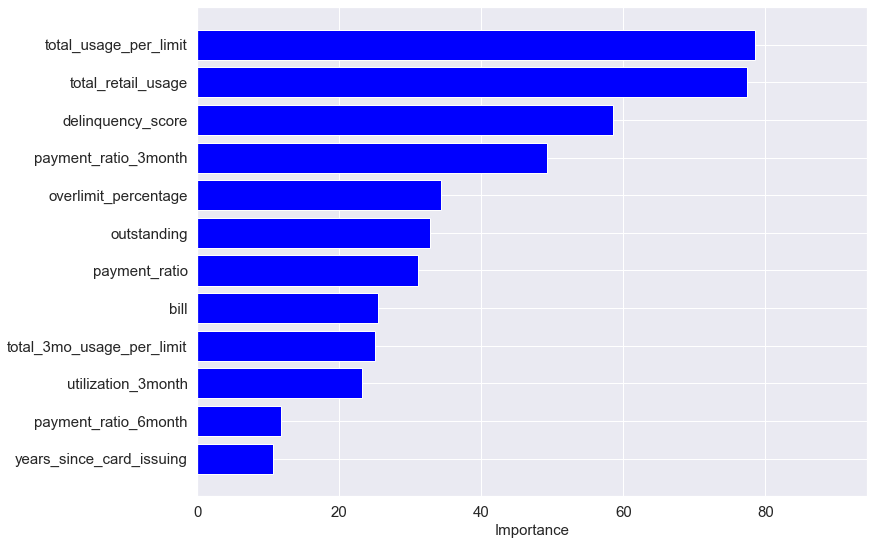

In [100]:
fs = fbooster.get_score(importance_type = 'gain') # available importance types: 'gain', 'cover', 'weight'
imp = sorted([(k, v) for k, v in fs.items()], key = lambda x:x[1], reverse = True)
imp.reverse()

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.barh(range(len(imp)), [v for k, v in imp], color="blue",  align='center')
plt.yticks(range(len(imp)), [k for k, v in imp], fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Importance',fontsize=15)
plt.ylim([-1, len(imp)])
plt.xlim([0, max([v for k, v in imp])*1.2])
plt.show()

Gain importance tells us the predictor relative contribution on each of the tree in the model. As you can see the **total_usage_per_limit**, **total_retail_usage**, and **delinquency_score** are the highest contributor to the model

Furthermore, if we want to see the more specific explanation of these predictors SHAP module could be used

# Score the dataset

Create a new column with the prediction (probability of default).

In [101]:
col_score = 'LR_SCORE'
col_score1 = 'XGB_SCORE'

data[col_score] = lr_scored
print('Column',col_score,'with the prediction added/modified. Number of columns:',data.shape[1])

data[col_score1] = fxgb_scored
print('Column',col_score1,'with the prediction added/modified. Number of columns:',data.shape[1])

Column LR_SCORE with the prediction added/modified. Number of columns: 51
Column XGB_SCORE with the prediction added/modified. Number of columns: 52


# Performance characteristics
Performance characteristics of the models (Gini, Lift, KS) and their visualisations.

In [102]:
from ia_pkg.metrics import gini, lift, kolmogorov_smirnov
lift_perc = 10

## Performance per sample

In [103]:
perf = pd.DataFrame({'sample':[
    'train',
    'valid',
    'test'    
    ], 'LR_gini':[
    gini(data[train_mask][col_target],data[train_mask][col_score]) #train
    ,gini(data[valid_mask][col_target],data[valid_mask][col_score]) #valid
    ,gini(data[test_mask][col_target],data[test_mask][col_score]) #test
    ], 'XGB_gini':[
    gini(data[train_mask][col_target],data[train_mask][col_score1]) #train
    ,gini(data[valid_mask][col_target],data[valid_mask][col_score1]) #valid
    ,gini(data[test_mask][col_target],data[test_mask][col_score1]) #test
    ], 'LR_lift'+str(lift_perc):[
    lift(data[train_mask][col_target],-data[train_mask][col_score],lift_perc) #train
    ,lift(data[valid_mask][col_target],-data[valid_mask][col_score],lift_perc) #valid
    ,lift(data[test_mask][col_target],-data[test_mask][col_score],lift_perc) #test
    ], 'XGB_lift'+str(lift_perc):[
    lift(data[train_mask][col_target],-data[train_mask][col_score1],lift_perc) #train
    ,lift(data[valid_mask][col_target],-data[valid_mask][col_score1],lift_perc) #valid
    ,lift(data[test_mask][col_target],-data[test_mask][col_score1],lift_perc) #test
    ], 'LR_KS':[
    kolmogorov_smirnov(data[train_mask][col_score],data[train_mask][col_target]) #train
    ,kolmogorov_smirnov(data[valid_mask][col_score],data[valid_mask][col_target]) #valid
    ,kolmogorov_smirnov(data[test_mask][col_score],data[test_mask][col_target]) #test
    ], 'XGB_KS':[
    kolmogorov_smirnov(data[train_mask][col_score1],data[train_mask][col_target]) #train
    ,kolmogorov_smirnov(data[valid_mask][col_score1],data[valid_mask][col_target]) #valid
    ,kolmogorov_smirnov(data[test_mask][col_score1],data[test_mask][col_target]) #test
    ]}).set_index('sample')

In [104]:
display(perf)

,LR_gini,XGB_gini,LR_lift10,XGB_lift10,LR_KS,XGB_KS
sample,,,,,,
train,0.49498,0.751245,3.424419,4.860177,0.348503,0.589378
valid,0.56884,0.742122,4.039382,4.756047,0.428604,0.610579
test,0.50732,0.712476,3.437517,4.419664,0.370417,0.576395


There is a huge difference on overall performance generated by these models. Could be data leakage issue on XGB model since the performance on valid and test is too high, need further investigation to prove it.

## ROC Curve

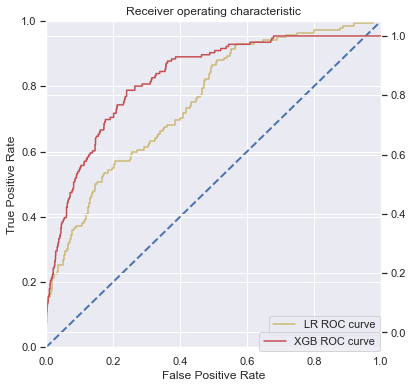

In [105]:
from sklearn.metrics import roc_curve

# Compute ROC curve for each models
fpr = dict()
fpr = dict()
fpr1 = dict()    
tpr1 = dict()

fpr, tpr, _ = roc_curve(data[test_mask][col_target], data[test_mask][col_score])
fpr1, tpr1, _ = roc_curve(data[test_mask][col_target], data[test_mask][col_score1])

#Plot of a ROC curve
f, ax1 = plt.subplots(figsize=(6,6))
lw = 2
ax1.plot(fpr, tpr, color='y',label='LR ROC curve')
ax1.plot([0, 1], [0, 1], color='b', lw=lw, linestyle='--') 

ax2 = ax1.twinx()
ax2.plot(fpr1, tpr1, color='r',label='XGB ROC curve')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver operating characteristic')
ax1.legend(bbox_to_anchor=(1, 0.1), borderaxespad=0.1)
ax2.legend(bbox_to_anchor=(1, 0.05), borderaxespad=0.1)
plt.show()

## Score Linearity on Holdout Sample

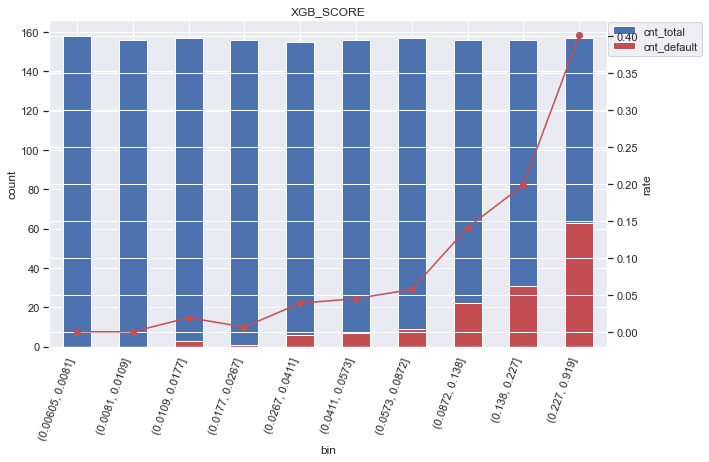

In [106]:
from ia_pkg.plots import plot_score_linearity
plot_score_linearity(data[test_mask],
                    col_score=col_score1,
                    col_target=col_target,
                    bins=10)

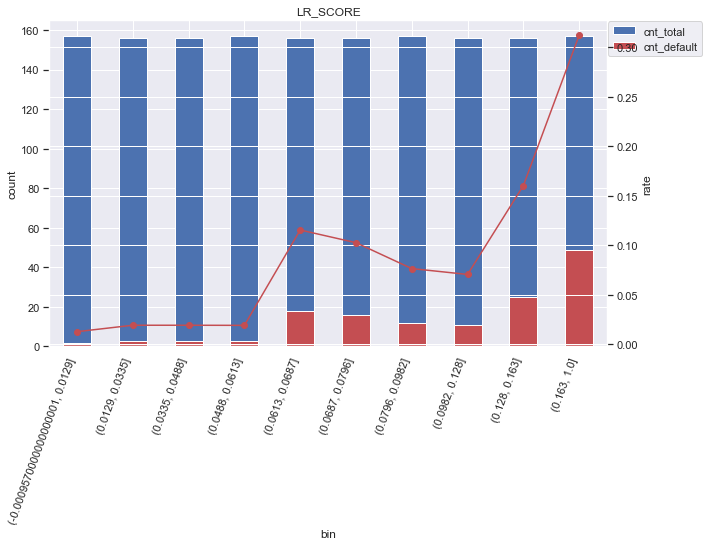

In [107]:
plot_score_linearity(data[test_mask],
                    col_score=col_score,
                    col_target=col_target,
                    bins=10)

Score distribution is plotted in decile to show the linearity of the output score when we link it to their actual default rate.

As you can see XGB could produce more consistent monotonicity than LR model, the reason is higher gini on XGB model

Also when we see the PD score on x-axis for both models, it seems the spread tends to gathered at lower PD value, so default threshold 0.5 for cutoff would not be relevant in this case

## Cut-Off Estimation

The LR_SCORE cutoff to 2.50% default rate estimation: 0.014820313514992852
The XGB_SCORE cutoff to 2.50% default rate estimation: 0.017703233286738396


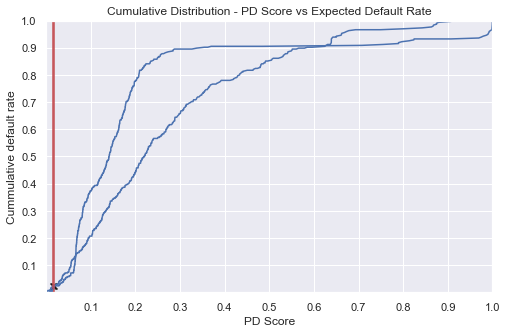

In [108]:
from ia_pkg.function import cutoff_df
from ia_pkg.plots import cutoff_plot

# Initialized all variable (expected default rate and scores)
exp_def_rate =0.025 # setting up the 2.5% expected default rate
scores = [col_score, col_score1]

# plot cutoff score
fig, ax = plt.subplots(figsize=(8,5))
for s in scores:
    dt = cutoff_df(data[valid_mask|test_mask],
                   col_score=s,
                   col_target=col_target)
    cutoff_plot(dt,
                col_score=s,
                exp_def_rate=exp_def_rate,
                ax=ax)

plt.title('Cumulative Distribution - PD Score vs Expected Default Rate')
plt.xlabel('PD Score')
plt.ylabel('Cummulative default rate')
plt.show()

Answering the problem task, the cutoff score is estimated by plotting the cumulative distribution of default rate to sorted score.

Two models presented to see the optimal cutoff to manage below 2.5% default rate on the portfolio

From the graph, we can decide for each cutoff score

**LR model cutoff score : 0.01482** 

**XGB model cutoff score : 0.0177**

# Conclusion

- Credit score is created to predict the probability of default on provided dataset


- Transformation and selection procedures is done to find the most useful predictors to the target


- Two models(LR and XGB) with different methods are presented to be compared. From the evaluation, XGB has better performance than LR


- The *deliquency_score* and *total_usage_per_limit* predictors considered as the highest contributor on both models


- Decision for the choosed model not yet to be made since we need further investigation of too high performance and interpretability on one of the model (XGB model)


- Optimal cutoff for 2.5% default rate : LR model is 0.01482 and XGB model is 0.0177